## Loading the converted EELs MAP

In [1]:
#import all we need --> set ipympl for inline graphic interaction
import matplotlib.pyplot as plt
import hyperspy.api as hs
import numpy as np
import exspy
import scipy
import os
import mplcyberpunk
import matplotlib 
import h5py
from Added_Functions import Set_Wrong_Pixels_to_NaN, Set_Wrong_Pixels_to_Zero, Set_Wrong_Pixels_to_MeanValue
plt.style.use('cyberpunk')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
#need to be set for the interactive GUI
%matplotlib ipympl

In [16]:
## loading data from the TVIPS EELS converter (nc format)
# read array from nc file with h5py
## MAG 2: EELS MAP setup
# Energy_shift_eV = 60
# nm/px =  0.22742
fp = "/masc_shared/ag_volz/pn_data/OM/raw_data/2024_InSe/2024_06_25_SO020_InSe/"
# EELS_File = h5py.File(os.path.join(fp,'InSe_32x64x300000us_converted.nc'),'r') '
#nm_per_px = 0.22742
# ev_per_channel = 0.3468208092485549

EELS_File = h5py.File(os.path.join(fp,'InSe_C_K_edge_32x32x400000us_converted.nc'),'r') 

In [17]:
#set plot size

cm = 1/2.54  # centimeters in inches
plt.rcParams['figure.figsize'] = [8*cm, 8*cm]

In [18]:
## extract the converted 4D dataset out of it and load it as Signal into hyperspy
EELS_MAP = EELS_File['converted_data/data_4d']
EELS_MAP = hs.signals.Signal2D(EELS_MAP)
EELS_MAP.set_signal_type('EELS')

In [19]:
### set wierd pixels to nan --> could also replace with mean spectrum of the sourrounding pixels
#determine treshhold from sum of mean spectrum
treshhold = np.sum(np.asarray(EELS_MAP.mean()))
meanvalue = np.mean(np.asarray(EELS_MAP.mean()))
#map filter function across the dataset
# EELS_MAP.map(Set_Wrong_Pixels_to_NaN,treshhold=treshhold)
# EELS_MAP.map(Set_Wrong_Pixels_to_Zero,treshhold=treshhold)
EELS_MAP.map(Set_Wrong_Pixels_to_MeanValue,treshhold=treshhold, MeanValue=meanvalue)

[########################################] | 100% Completed | 100.91 ms


In [20]:
EELS_MAP.plot(navigator_kwds={'cmap':'viridis'})

In [21]:
## there is a constant bkg offset??
offset_value = 980
EELS_MAP = EELS_MAP-offset_value

In [22]:
#Offset corrected Map
EELS_MAP.plot(navigator_kwds={'cmap':'viridis'})

In [23]:
## Define the window for the extraction of 1D spectra from the stored 2D spectra 
segments = [[[0.8711,223],[252.1,33.05]]]
linewidth = 20 ##use to select integration width
Line_marker = hs.plot.markers.Lines(segments, transform='data',linewidth=linewidth, colors=(0.0, 1, 1, 0.4),linestyles='solid')
EELS_MAP.add_marker(Line_marker)

In [24]:
## extract spectrum from ROI

## define ROI and measure the rotation angle needed if image should be rotated
ROI_Line = hs.roi.Line2DROI(x1=segments[0][0][0], y1=segments[0][0][1], x2=segments[0][1][0], y2=segments[0][1][1], linewidth=linewidth)
Rot_Angle = ROI_Line.angle(axis='horizontal', units='degrees')

## create spectrum
EELS_MAP = ROI_Line.profile_line(    
    EELS_MAP.data,
    segments[0][0],
    segments[0][1],
    [EELS_MAP.axes_manager[2], EELS_MAP.axes_manager[3]], #navigation axis, energy loss axis
    linewidth=linewidth,
    order=1,
    mode='constant',
    cval=0.0,
)
#needs to be converted to Signal
EELS_MAP = hs.signals.Signal1D(EELS_MAP)
EELS_MAP.set_signal_type('EELS')


In [25]:
# Set Microscope Parameters
EELS_MAP.set_microscope_parameters(
    beam_energy=200,
    convergence_angle=21, #CLA2
    collection_angle=15, # ENTA2
    toolkit=None,
    display=True,
)

In [26]:
## Calibrate the Signal
nm_per_px = 0.22742
ev_per_channel = 0.3468208092485549
Energy_Shift = 560-330

EELS_MAP.axes_manager[0].name = 'y'
EELS_MAP.axes_manager[0].scale = nm_per_px
EELS_MAP.axes_manager[0].units = 'nm'

EELS_MAP.axes_manager[1].name = 'x'
EELS_MAP.axes_manager[1].scale = nm_per_px
EELS_MAP.axes_manager[1].units = 'nm'

EELS_MAP.axes_manager[2].name = 'Energy Loss'
EELS_MAP.axes_manager[2].scale = ev_per_channel
EELS_MAP.axes_manager[2].units = 'eV'
EELS_MAP.axes_manager[2].offset = Energy_Shift

EELS_MAP.axes_manager.gui()

In [27]:
##calibrated 3D Dataset
EELS_MAP.plot(navigator_kwds={'cmap':'viridis'})

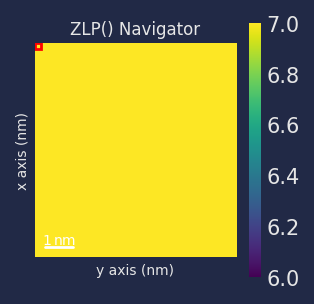

In [14]:
#ZLP Shift Map
ZLP_Center = EELS_MAP.estimate_zero_loss_peak_centre()
ZLP_Center.plot(navigator_kwds={'vmin':6,'vmax':7, 'cmap': 'viridis'})

In [15]:
## Continoue here --> make peak shift map etc. // ask JH regading the conversion of the data
EELS_MAP.align_zero_loss_peak(calibrate=True, 
                                      also_align=[], 
                                      print_stats=True, 
                                      subpixel=True, 
                                      mask=None, 
                                      signal_range=None, 
                                      show_progressbar=None, 
                                      crop=False)

EELS_MAP.plot(navigator_kwds={'cmap': 'viridis'})

Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	264
std:	30.7

min:	232
Q1:	232
median:	237
Q3:	296
max:	297
[########################################] | 100% Completed | 100.88 ms
[########################################] | 100% Completed | 201.96 ms
[########################################] | 100% Completed | 100.70 ms


In [28]:
## add: determine thickness map 
#Calculate t/y with treshold --> set to the end of the 
thickness_MAP = EELS_MAP.estimate_thickness(
    threshold=2/EELS_MAP.axes_manager[2].scale)


thickness_MAP.plot(navigator_kwds={'vmin':0.4,'vmax':0.8,'cmap': 'viridis'})
# thickness.data

IndexError: Stop value below axis low bound for  axis <Energy Loss axis, size: 316>.value: 5.766667 low_bound: 230.000000

In [16]:
## calculate mean free path: Malis equation or Iakoubovskii ( for large collection angles > 10 mrad @ 200 kV)
E_0 = 200 # acceleration Voltage in kV
rho = 2.2 # material density in g/cm³ # rho(Al2O3) = 3.98 g/cm³, rho(InSe) = 5.8, rho(C) = 2.2, rho(W) = 19.25
F = (1+E_0/1022)/(1+E_0/511)**2 # relativisic correction factor
alpha = 21 #convergence angle mrad
beta = 15 # collection angle mrad 
delta = abs(alpha**2-beta**2)
Theta_E = (5.5*rho**0.3)/(F*E_0)
Theta_C = 20 # mrad 

# #Iakoubovskii  https://doi.org/10.1002/jemt.20597
mean_free_path_Iakoubovskii  = ((200*F*E_0)/(11*rho**0.3))/np.log((alpha**2+beta**2+2*Theta_E**2+delta**2)/(alpha**2+beta**2+2*Theta_C**2+delta**2)*(Theta_C**2/Theta_E**2))
print('Iakoubovskii:', mean_free_path_Iakoubovskii)

## Malis only valid for small collection angles
E_m = 15.9 # eV for Al2o3
mean_free_path_Malis = (106*F*(E_0/E_m))/(np.log(2*beta*E_0/E_m))
print('Malis:', mean_free_path_Malis)

Iakoubovskii: 151.19946744587486
Malis: 138.7947300975339


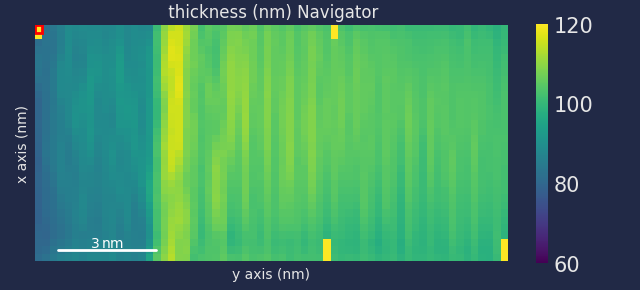

In [17]:
## Caculate the Thickness Map in nm with mean free path
thickness_MAP_nm = EELS_MAP.estimate_thickness(
    threshold=2/EELS_MAP.axes_manager[2].scale, density=rho ,
    mean_free_path=mean_free_path_Iakoubovskii)

thickness_MAP_nm.plot(navigator_kwds={'vmin':60,'vmax':120,'cmap':'viridis'})

Iakoubovskii: 126.5645688803562


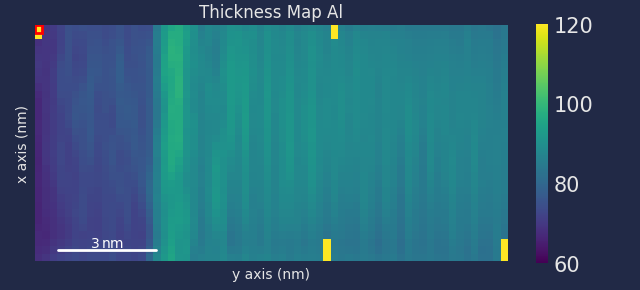

Iakoubovskii: 113.04429967382866


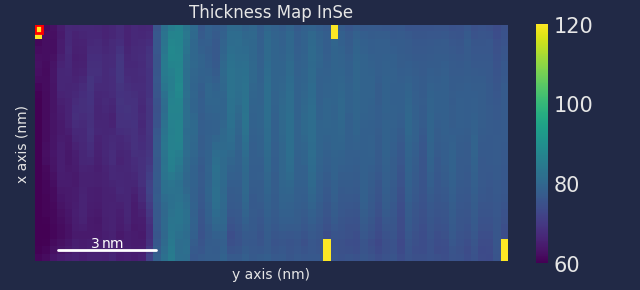

Iakoubovskii: 151.19946744587486


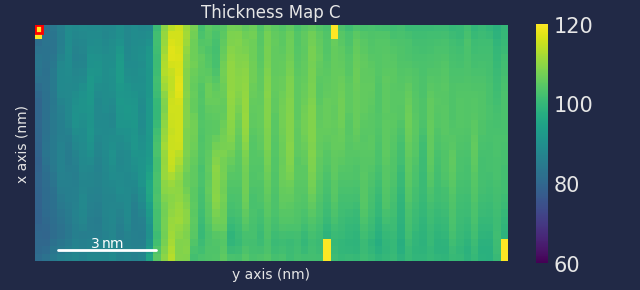

In [18]:
## Caculate the Thickness Map in nm with mean free path -->  make 3 maps with different rho values --> about 90 nm for each material!
rho = 3.98

mean_free_path_Iakoubovskii  = ((200*F*E_0)/(11*rho**0.3))/np.log((alpha**2+beta**2+2*Theta_E**2+delta**2)/(alpha**2+beta**2+2*Theta_C**2+delta**2)*(Theta_C**2/Theta_E**2))
print('Iakoubovskii:', mean_free_path_Iakoubovskii)

thickness_MAP_nm_Al = EELS_MAP.estimate_thickness(
    threshold=2/EELS_MAP.axes_manager[2].scale, density=rho,
    mean_free_path=mean_free_path_Iakoubovskii)


thickness_MAP_nm_Al.plot(navigator_kwds={'vmin':60,'vmax':120,'cmap':'viridis','title':'Thickness Map Al'})


rho = 5.8

mean_free_path_Iakoubovskii  = ((200*F*E_0)/(11*rho**0.3))/np.log((alpha**2+beta**2+2*Theta_E**2+delta**2)/(alpha**2+beta**2+2*Theta_C**2+delta**2)*(Theta_C**2/Theta_E**2))
print('Iakoubovskii:', mean_free_path_Iakoubovskii)

thickness_MAP_nm_InSe = EELS_MAP.estimate_thickness(
    threshold=2/EELS_MAP.axes_manager[2].scale, density=rho ,
    mean_free_path=mean_free_path_Iakoubovskii)



thickness_MAP_nm_InSe.plot(navigator_kwds={'vmin':60,'vmax':120,'cmap':'viridis','title':'Thickness Map InSe'})

rho = 2.2

mean_free_path_Iakoubovskii  = ((200*F*E_0)/(11*rho**0.3))/np.log((alpha**2+beta**2+2*Theta_E**2+delta**2)/(alpha**2+beta**2+2*Theta_C**2+delta**2)*(Theta_C**2/Theta_E**2))
print('Iakoubovskii:', mean_free_path_Iakoubovskii)

thickness_MAP_nm_C = EELS_MAP.estimate_thickness(
    threshold=2/EELS_MAP.axes_manager[2].scale, density=rho ,
    mean_free_path=mean_free_path_Iakoubovskii)



thickness_MAP_nm_C.plot(navigator_kwds={'vmin':60,'vmax':120,'cmap':'viridis','title':'Thickness Map C'})

In [29]:
## crop signal left and right

EELS_MAP.crop_signal(left_value = 240.0, right_value = 330.0)

In [30]:
## need to plot single spect to use interactive bkg substraction is desired
EELS_MAP.plot(navigator_kwds={'cmap': 'viridis'})

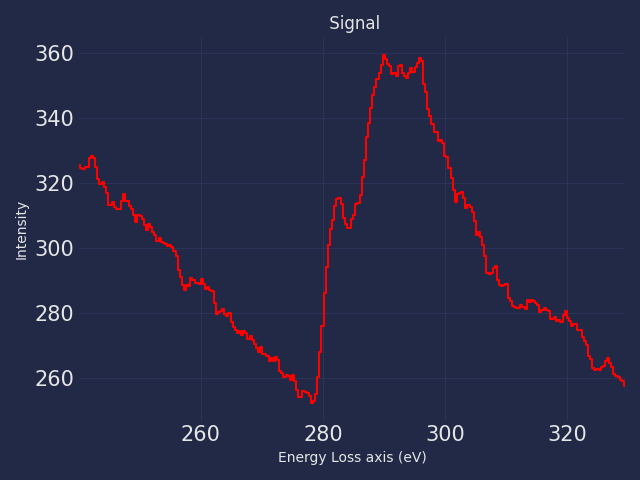

/home/massmeye/.conda/envs/4dstem/lib/python3.11/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


In [31]:
## use mean spekt to define bkg substraction
EELS_MAP_mean_spekt = EELS_MAP.nanmean()
EELS_MAP_mean_spekt.plot()
## get window for bkg substraction
signal_background_corrected = EELS_MAP_mean_spekt.remove_background(signal_range='interactive', 
    background_type='Exponential',
    polynomial_order=2,
    fast=True,
    zero_fill=True,
    plot_remainder=True,
    show_progressbar=None,
    return_model=True,
    display=True,
    toolkit=None,
)       

In [ ]:
## since the bkg function produces to much output change the config to be able to use it:
## tutorial here: https://stackoverflow.com/questions/43490495/how-to-set-notebookapp-iopub-data-rate-limit-and-others-notebookapp-settings-in

In [29]:
## get window for bkg substraction  ##signal_range=(4.23,6.94)
EELS_MAP_background_corrected= EELS_MAP.remove_background(signal_range=(240.0,270.0), 
    background_type='Power law',
    polynomial_order=3,
    fast=False,
    zero_fill=True,
    plot_remainder=False,
    show_progressbar=True,
    return_model=True,
    display=False,
    toolkit=None,
)                                                         


  0%|          | 0/1023 [00:00<?, ?it/s]

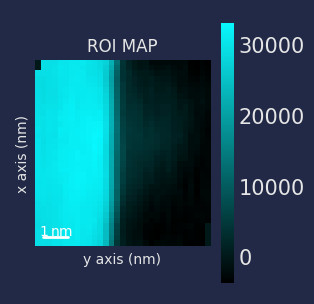

In [34]:
## plot the bkg substracted map and extract peak maps by gui
EELS_MAP_background_corrected[0].plot(navigator_kwds={'cmap': 'viridis'})

#no good way to save and reload the rois at the moment
rois = [hs.roi.SpanROI(left=278.382, right=338.035)]
## extract maps from peaks
rois, roi_sums = hs.plot.plot_roi_map(
    signal = EELS_MAP_background_corrected[0], 
    rois = rois,
    single_figure=False,
    title='ROI MAP',
    # single_figure_kwargs={'vmin':10,'vmax':200,'suptitle': 'Test'},
)


In [36]:
fsp

'/masc_shared/ag_volz/pn_data/OM/raw_data/2024_InSe/2024_06_25_SO020_InSe//Evaluation'

In [37]:
rois

#no good way to save and reload the rois at the moment
rois = [hs.roi.SpanROI(left=278.382, right=338.035)]

## save the roi maps - visualize selected ROIS
fsp = fp + '/Evaluation'
if False:
    roi_sums[0].save(os.path.join(fsp,'C_ROI_MAP'))

In [38]:
## create deep copy before altering the data
EELS_MAP_Modeled = EELS_MAP_background_corrected[0].deepcopy()

In [50]:
## create line scan out of map data
AVG_Line_Scan = EELS_MAP_Modeled.nanmean(axis=1)
AVG_Line_Scan.plot(vmin=0, vmax=200, navigator_kwds={'cmap': 'viridis'})
## crop the spectra
AVG_Line_Scan.crop_signal(left_value = 240.0, right_value  = 337.0)

In [51]:
## save the line scan
AVG_Line_Scan.save(os.path.join(fsp,'C_Spectrum_AVG_Line_Scan'))

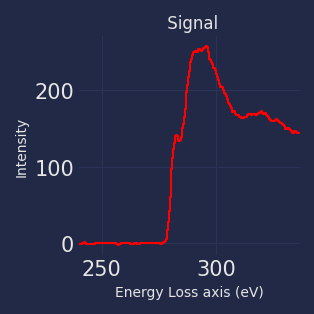

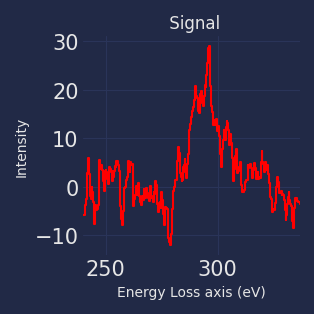

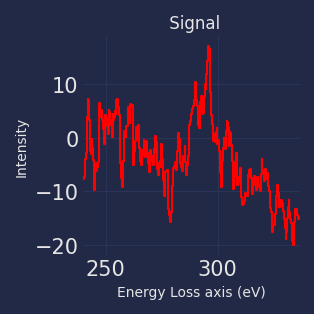

Overwrite '/masc_shared/ag_volz/pn_data/OM/raw_data/2024_InSe/2024_06_25_SO020_InSe/Evaluation/C_Spectrum_C_Layer.hspy' (y/n)?
 y
Overwrite '/masc_shared/ag_volz/pn_data/OM/raw_data/2024_InSe/2024_06_25_SO020_InSe/Evaluation/C_Spectrum_InSe_Layer.hspy' (y/n)?
 y
Overwrite '/masc_shared/ag_volz/pn_data/OM/raw_data/2024_InSe/2024_06_25_SO020_InSe/Evaluation/C_Spectrum_Al2O3_Layer.hspy' (y/n)?
 y


In [52]:
## extract the C spectra
C_Spectrum_C_Layer = AVG_Line_Scan.inav[0:9].mean()
C_Spectrum_C_Layer.plot()

C_Spectrum_InSe_Layer = AVG_Line_Scan.inav[17:21].mean()
C_Spectrum_InSe_Layer.plot()

C_Spectrum_Al2O3_Layer = AVG_Line_Scan.inav[22:27].mean()
C_Spectrum_Al2O3_Layer.plot()

#save the spectra
if True:
    C_Spectrum_C_Layer.save(os.path.join(fsp,'C_Spectrum_C_Layer'))
    C_Spectrum_InSe_Layer.save(os.path.join(fsp,'C_Spectrum_InSe_Layer'))
    C_Spectrum_Al2O3_Layer.save(os.path.join(fsp,'C_Spectrum_Al2O3_Layer'))



In [40]:
## crop 0 region
AVG_Line_Scan.crop_signal(left_value=10.0)

ValueError: The value is out of the axis limits

In [27]:
AVG_Line_Scan.axes_manager.gui()

In [37]:
## extract spectra from line scan
spekt_C = hs.signals.Signal1D(AVG_Line_Scan.data[2])
# there is probably a smarter way to do this
spekt_C.axes_manager[0].name = AVG_Line_Scan.axes_manager[1].name
spekt_C.axes_manager[0].scale = AVG_Line_Scan.axes_manager[1].scale
spekt_C.axes_manager[0].units = AVG_Line_Scan.axes_manager[1].units
spekt_C.axes_manager[0].offset = AVG_Line_Scan.axes_manager[1].offset

spekt_InSe_1 = hs.signals.Signal1D(AVG_Line_Scan.data[17])
# there is probably a smarter way to do this
spekt_InSe_1.axes_manager[0].name = AVG_Line_Scan.axes_manager[1].name
spekt_InSe_1.axes_manager[0].scale = AVG_Line_Scan.axes_manager[1].scale
spekt_InSe_1.axes_manager[0].units = AVG_Line_Scan.axes_manager[1].units
spekt_InSe_1.axes_manager[0].offset = AVG_Line_Scan.axes_manager[1].offset

spekt_Al2O3 = hs.signals.Signal1D(AVG_Line_Scan.data[30])
# there is probably a smarter way to do this
spekt_Al2O3.axes_manager[0].name = AVG_Line_Scan.axes_manager[1].name
spekt_Al2O3.axes_manager[0].scale = AVG_Line_Scan.axes_manager[1].scale
spekt_Al2O3.axes_manager[0].units = AVG_Line_Scan.axes_manager[1].units
spekt_Al2O3.axes_manager[0].offset = AVG_Line_Scan.axes_manager[1].offset



<Axes: xlabel='Energy Loss (eV)', ylabel='Intensity'>

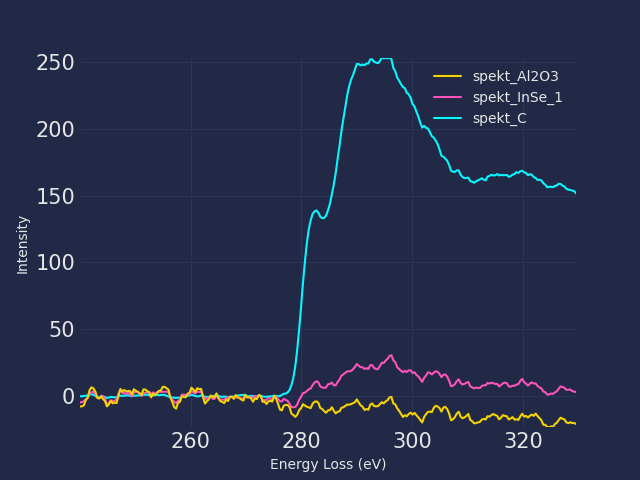

In [38]:
#plot multiple spectra in one figure
hs.plot.plot_spectra([spekt_C,spekt_InSe_1,spekt_Al2O3],
    style='overlap',
    color=None,
    linestyle=None,
    drawstyle='default',
    padding=1.0,
    legend=['spekt_C','spekt_InSe_1','spekt_Al2O3'],
    legend_picking=True,
    legend_loc='upper right',
    fig=None,
    ax=None,
    auto_update=None,
)

## UMAP

In [38]:
## quick installation of UMAP

import sys
!{sys.executable} -m pip install umap-learn
!{sys.executable} -m pip install MCRLLM
!{sys.executable} -m pip install pysptools


In [35]:
import numpy as np
import matplotlib.pyplot as plt

import tifffile as tif

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import umap
import MCRLLM
import os
import scipy
from pathlib import Path

##import 
from Added_Functions import Normalize_Array_to_Sum, Normalize_Array_to_Max

In [67]:
## create deep copy before altering the data
EELS_MAP_Modeled = EELS_MAP_background_corrected[0].deepcopy()

In [68]:
## Refine the dataset 

## Norm spectra to sum 
# EELS_MAP_Modeled.map(Normalize_Array_to_Sum)
# EELS_MAP_Modeled.map(Normalize_Array_to_Max)

#crop signal axis --> remove 0 values 
# EELS_MAP_Modeled.crop_signal(left_value = 10.0)

## Hanning Window for edge values
# EELS_MAP_Modeled.hanning_taper(side='both', channels=20, offset=0)

## crop the annoying datapoints
EELS_MAP_Modeled.crop(axis=1,start=2,end=29)

In [69]:
EELS_MAP_Modeled.plot()

In [45]:
6/0.22742


26.382903878286868

In [32]:
## create 3 regions of the map
C_region = EELS_MAP_Modeled.deepcopy()
InSe_region = EELS_MAP_Modeled.deepcopy()
Al_region = EELS_MAP_Modeled.deepcopy()

In [40]:
C_region.axes_manager.gui()

In [33]:
## crop the 3 regions
C_region.crop(axis=0,start=0,end=15)
InSe_region.crop(axis=0,start=16,end=27)
Al_region.crop(axis=0,start=28)

In [34]:
# Plot the components
C_region.plot(navigator_kwds={'cmap': 'viridis', 'vmin':70, 'vmax':130})
InSe_region.plot(navigator_kwds={'cmap': 'viridis', 'vmin':70, 'vmax':130})
Al_region.plot(navigator_kwds={'cmap': 'viridis', 'vmin':70, 'vmax':130})

In [70]:
## read data from hyperspy dataset
data = EELS_MAP_Modeled.data #map data
# data = Al_region.data #C_region data
# data = InSe_region.data #C_region data
# saving the image shape
img_shape = data.shape
print(img_shape)

#define energy axis
E0 = 0
energy_loss = np.arange(E0,img_shape[2]+E0)
print(energy_loss.shape)

# spectral data needs to be last and x*y 
data = data.reshape(img_shape[0]*img_shape[1],img_shape[2])
data.shape

(27, 31, 259)
(259,)


(837, 259)

## Dimensionality reduction by PCA

The Principal Component Analysis reveals two significant components determined from the ellbow criterium of the scree plot. The scatter plot of the two significant components revelas 4 visible clusters.

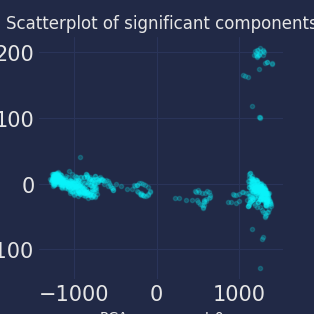

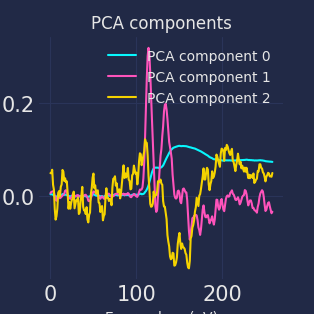

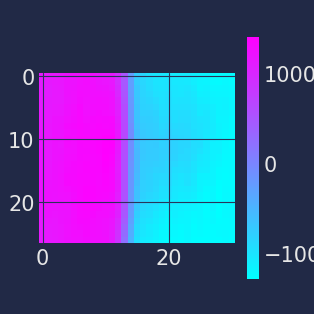

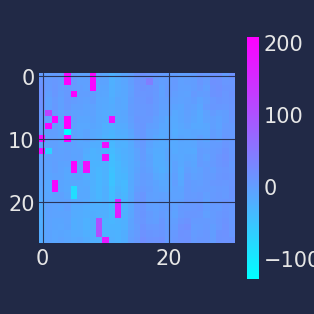

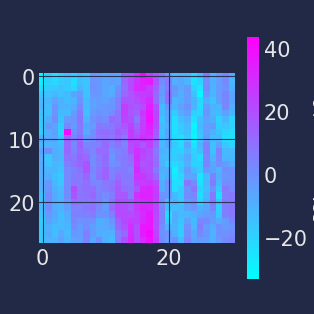

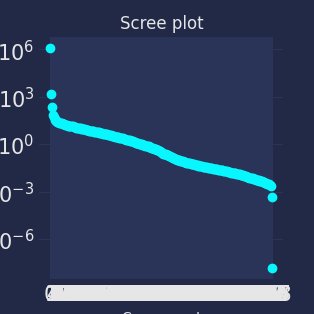

In [71]:
# execute the PCA
pca = PCA()
pca_res = pca.fit_transform(data).T

# Scree plot
fig = plt.figure()
xticks = range(0,len(pca.explained_variance_))
plt.plot(xticks,pca.explained_variance_,'o')
plt.xlabel('Component')
plt.xticks(xticks)
plt.ylabel('Explained Variance')
plt.yscale('log')
plt.title('Scree plot')

n_significant_comp = 3

# Scatterplot of significant components
plt.figure()
plt.scatter(pca_res[0],pca_res[1],marker='.',alpha=.2)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')
plt.title('Scatterplot of significant components')
plt.show()

# Plot of significant components (eigenspectra)
plt.figure()
for n,r in enumerate(pca.components_[:n_significant_comp]):
    plt.plot(energy_loss,r,label='PCA component '+str(n))
plt.ylabel('Intensity (a.u.)')
plt.xlabel('Energy loss (eV)')
plt.legend(loc='upper right',frameon=False)
plt.title('PCA components')
plt.show()

# Spatial distribution of the components
pca_imgs = pca_res.reshape(img_shape[2],img_shape[0],img_shape[1])
for n,r in enumerate(pca_imgs[:n_significant_comp]):
    plt.figure()
    plt.imshow(r)
    cbar = plt.colorbar()
    cbar.set_label('PCA component ' + str(n))
    plt.show()

## Clustering analysis of PCA results

Agglomerative clustering segments the 4 identified clusters and yields a first material map.

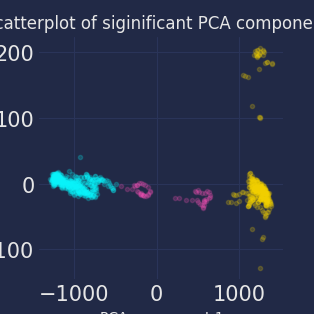

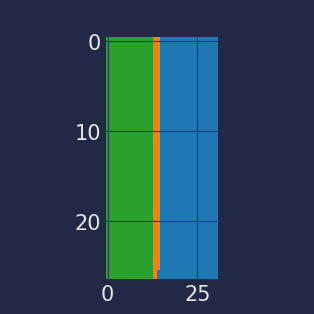

In [72]:
# set parameters
n_clusters = 3
n_significant_comp = 3
linkage = 'ward'

# execute the cluster analysis
AC     = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkage)
AC_res = AC.fit(pca_res[:n_significant_comp].T)

# Scatterplot of significant components with labeled clusters
fig1 = plt.figure()
for label in np.unique(AC_res.labels_):
    plt.scatter(pca_res[0][AC_res.labels_ == label],pca_res[1][AC_res.labels_ == label],marker='.',alpha=.2)
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('Scatterplot of siginificant PCA components')
plt.show()

# Material map
AC_imgs = AC_res.labels_.reshape(img_shape[0],img_shape[1])
fig2 = plt.figure()
plt.imshow(AC_imgs, cmap='tab10', vmax=10, aspect='2.5')
plt.show()

## Dimensionality reduction by UMAP

Uniform Manifold Approximation and Projection shows again 4 visible clusters. Other than PCA, the UMAP components don't have a physical meaning and don't translate to eigenspectra ut yield a better separation of the clusters than PCA by using a nonlinear algorithm to map the high dimensional space of the full spectra to lower dimensions. 

/tmp/ipykernel_102030/379963462.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10 = matplotlib.cm.get_cmap('tab10', 256)


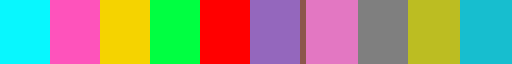

In [73]:
##create new colormap for UMAP

tab10 = matplotlib.cm.get_cmap('tab10', 256)
newcolors = tab10(np.linspace(0, 1, 256))
cyan = np.array([8/255, 247/255, 254/255, 1])
pink = np.array([254/255, 83/255, 187/255, 1])
yellow = np.array([245/255,211/255,0/255, 1])
green = np.array([0/255, 255/255, 65/255, 1])
red = np.array([255/255, 0/255, 0/255, 1])
violet = np.array([148/255, 103/255, 189/255, 1])

newcolors[:25, :] = cyan
newcolors[25:2*25, :] = pink
newcolors[2*25:3*25, :] = yellow
newcolors[3*25:4*25, :] = green
newcolors[4*25:5*25, :] = red
newcolors[5*25:6*25, :] = violet

newcmp= matplotlib.colors.ListedColormap(newcolors)
newcmp

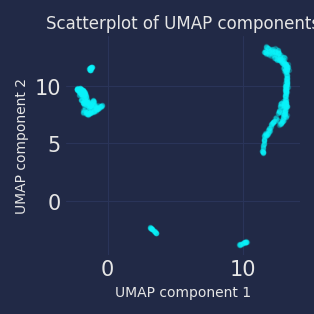

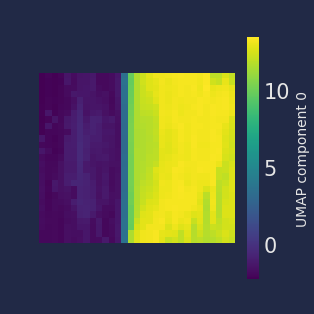

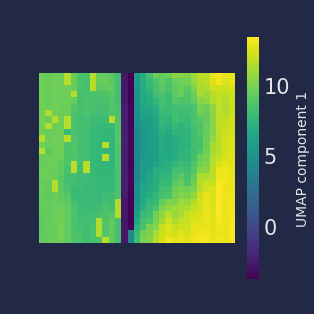

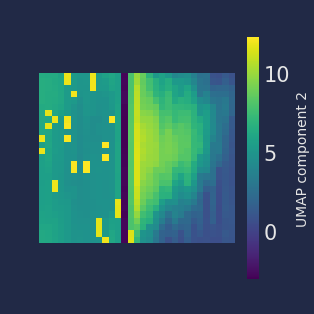

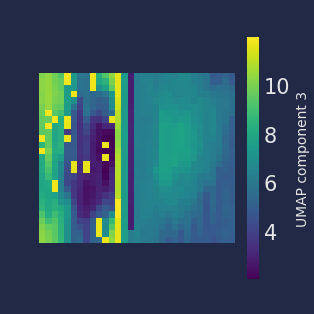

In [76]:
# set parameters
n_components = 4

# execute UMAP
umap_    = umap.UMAP(n_components=n_components)
umap_res = umap_.fit_transform(data).T

# Scatterplot of UMAP components
fig = plt.figure()
plt.scatter(umap_res[0],umap_res[1],marker='.',alpha=.2)
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.title('Scatterplot of UMAP components')
plt.tight_layout()

# Spatial distribution of the components
umap_imgs = umap_res.reshape(n_components,img_shape[0],img_shape[1])
for n,r in enumerate(umap_imgs):
    plt.figure()
    plt.imshow(r,cmap='viridis')
    plt.axis('off')
    cbar = plt.colorbar()
    cbar.set_label('UMAP component ' + str(n))

## Clustering analysis of UMAP results

Agglomerative clustering segments the 4 identified clusters and yields a material map of higher qualitiy than after PCA, evident from the fewer misclassified pixel at the inner edge of the mixed phase.

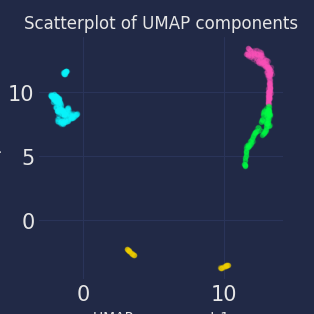

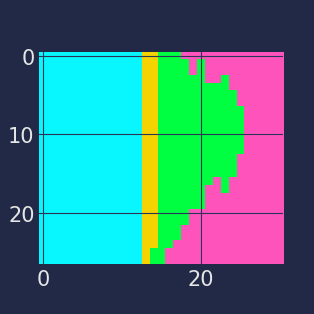

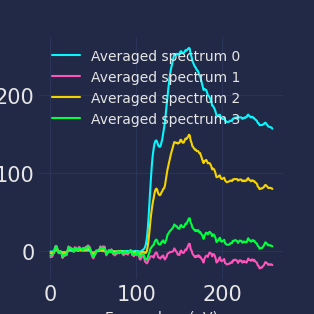

In [82]:
# set parameters
n_clusters = 4
linkage = 'ward'

# execute the cluster analysis
AC     = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkage)
AC_res = AC.fit(umap_res.T)

# Scatterplot of UMAP components with labeled clusters
fig1 = plt.figure()
for label in np.unique(AC_res.labels_):
    plt.scatter(umap_res[0][AC_res.labels_ == label],umap_res[1][AC_res.labels_ == label],marker='.',alpha=.2)
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.title('Scatterplot of UMAP components') 
plt.show()

# Material map
fig2 = plt.figure()
AC_imgs = AC_res.labels_.reshape(img_shape[0],img_shape[1])
plt.imshow(AC_imgs,cmap=newcmp,vmax=10)
plt.show()

# Averaged spectra for each cluster
fig3 = plt.figure()
avg_spectra = [np.mean(data[AC_res.labels_ == label],axis=0) for label in np.unique(AC_res.labels_)]
for n,spectrum in enumerate(avg_spectra):
    plt.plot(energy_loss,spectrum,label='Averaged spectrum '+str(n))
plt.xlabel('Energy loss (eV)')
plt.legend()
# plt.xticks(energy_loss)
plt.show()

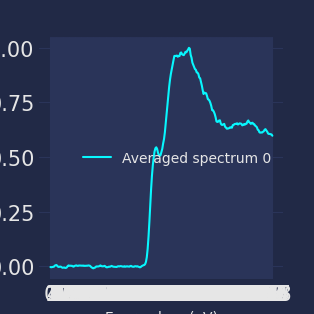

In [58]:
# remove the spectra, if needed
avg_spectra.pop(0)

#plot again
fig = plt.figure()
for n,spectrum in enumerate(avg_spectra):
    plt.plot(energy_loss,spectrum,label='Averaged spectrum '+str(n))
plt.xlabel('Energy loss (eV)')
plt.legend()
plt.xticks(energy_loss)
plt.show()

## Quantification of chemical composition by MCR-LLM
The averaged spectra of the UMAP segmentation are used as initalisation for Multivariate Curve Resolution by Log-Likelihood Maximization to further unmix the spectra and obtain the spatial chemical distiribution of the independent components. The mixed spectra of the mixed phase are disregarded for the quantification, as it is a mix of other components. MCR-LLM has inbuild initialisation methods. Depending on the dataset, these methods might yield the best possible results. Therefore, it is necessary to check the optained compositional maps and the unmixed spectra against the expectaion from the single ESI images and the high resolution EEL spectra, respectively. For the dataset at hand, we achieved the best possible results with the averaged spectra.

For the publication, we used 100 iterations just to be sure. However, the algorithm converges much faster and only a few iterations are actually necessary.

In [86]:
## use to rerun with selected components
avg_spectra = [ MCRLLM_res.S[1], MCRLLM_res.S[2]]

(837, 259)
Initializing with given spectra
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


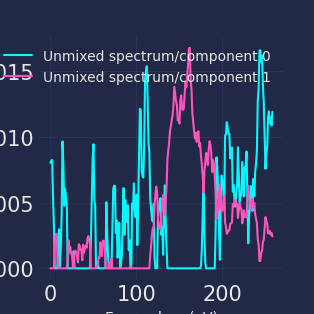

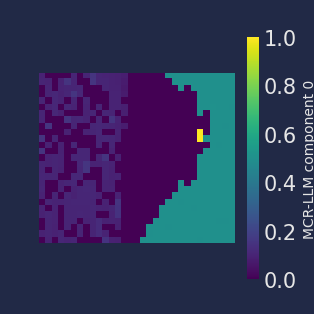

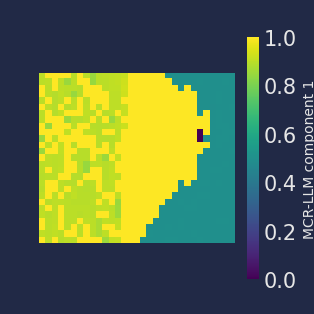

In [87]:
# removing the mixed phase from the spectra. Note: The mixed phase might have a different index for different runs of the script.
# avg_spectra.pop(1)

# Normalization of the averaged spectra to make them a usefull starting point for MCR-LLM. 
# The scaling factor is empiric and can be determined as the maximum value of the spectra from an alternative initiation like Kmeans or NFindr. 
# I could not discover a way of normalizing the averaged spectra to make them compatible with MCR-LLM right away. The scaling factor might need to be changed for a different datasets

# scaling_factor = 1
# avg_spectra = avg_spectra / np.amax(avg_spectra) * scaling_factor

# MCR-LLM parameters
n_components = 2
n_iter       = 10
init         = np.array(avg_spectra) # 'Kmeans' 'NFindr'
# init         = 'Kmeans' # 'Kmeans' 'NFindr'

print(data.shape)

# executing MCR-LLM: NOTE: DOES NOT WORK ON DATA WITH ZERO VALUES
MCRLLM_res = MCRLLM.mcrllm(data, n_components, init, n_iter)
# MCRLLM_res = MCRLLM.mcrllm(data_raw, n_components, init, n_iter)
# plot unmixed spectra
fig = plt.figure()
for n,spectrum in enumerate(MCRLLM_res.S):
    plt.plot(energy_loss,spectrum,label='Unmixed spectrum/component '+str(n))   
plt.legend()
plt.xlabel('Energy loss (eV)')
plt.ylabel('Intensity (a.u.)')

# plot chemical distributions of the unmixed components
MCRLLM_imgs = MCRLLM_res.C.T.reshape(n_components,img_shape[0],img_shape[1])
# MCRLLM_imgs = MCRLLM_res.C.T.reshape(n_components,img_shape_raw[1],img_shape_raw[2])
for n,r in enumerate(MCRLLM_imgs):
    plt.figure()
    # plt.imshow(r,vmin=0,vmax=1)
    plt.imshow(r,cmap='viridis')
    cbar = plt.colorbar()
    cbar.set_label('MCR-LLM component ' + str(n))
    plt.xticks([])
    plt.yticks([])

In [65]:
## save with hyperspy?
MCRLLM_maps = hs.signals.Signal2D(MCRLLM_imgs)
#set navigation axis
MCRLLM_maps.axes_manager[0].navigate=True
MCRLLM_maps.axes_manager[1].name = EELS_MAP_Modeled.axes_manager[0].name
MCRLLM_maps.axes_manager[1].scale = EELS_MAP_Modeled.axes_manager[0].scale
MCRLLM_maps.axes_manager[1].units = EELS_MAP_Modeled.axes_manager[0].units

MCRLLM_maps.axes_manager[2].name = EELS_MAP_Modeled.axes_manager[1].name
MCRLLM_maps.axes_manager[2].scale = EELS_MAP_Modeled.axes_manager[1].scale
MCRLLM_maps.axes_manager[2].units = EELS_MAP_Modeled.axes_manager[1].units



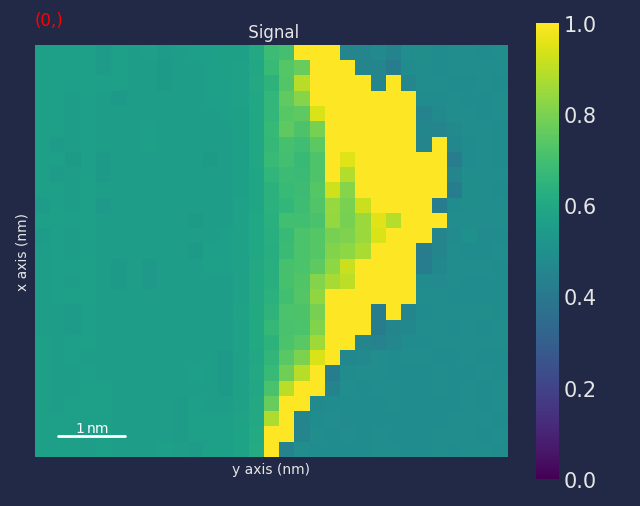

In [66]:
## maps slider plot
MCRLLM_maps.plot(navigator="slider",vmin = 0, vmax = 1, cmap = 'viridis')

In [67]:
## convert to EELS spectrum
MCRLLM_components = hs.signals.Signal1D(MCRLLM_res.S)
MCRLLM_components.axes_manager[0].name = 'Number of Component'
MCRLLM_components.axes_manager[1].name = EELS_MAP_Modeled.axes_manager[2].name
MCRLLM_components.axes_manager[1].scale = EELS_MAP_Modeled.axes_manager[2].scale
MCRLLM_components.axes_manager[1].units = EELS_MAP_Modeled.axes_manager[2].units
MCRLLM_components.axes_manager[1].offset = EELS_MAP_Modeled.axes_manager[2].offset

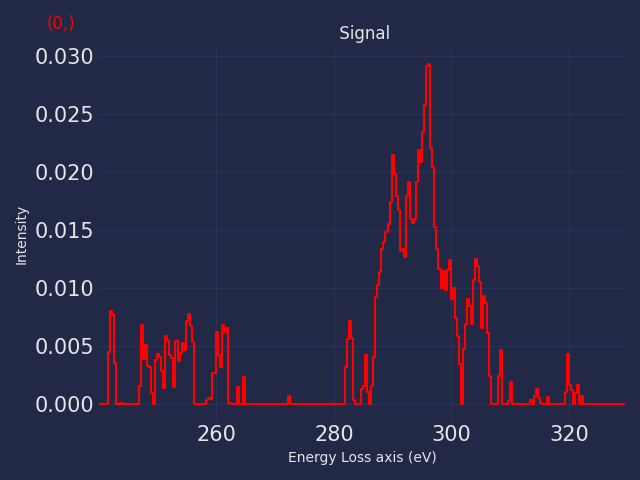

In [68]:
## component slider plot
MCRLLM_components.plot(navigator="slider")

Text(0.5, 1.0, 'Components')

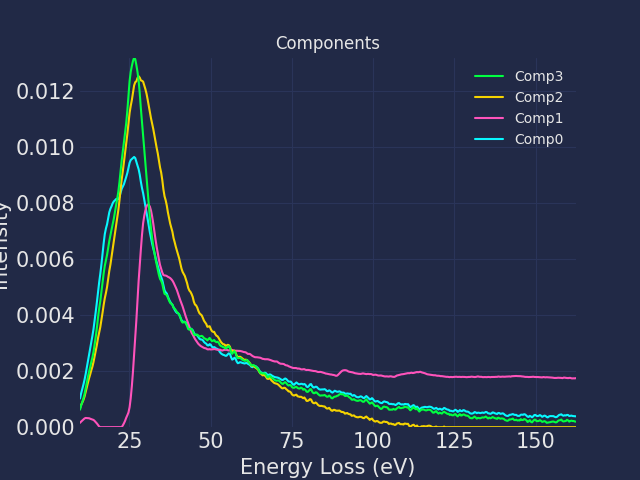

In [135]:
## all components calibrated
##plot

hs.plot.plot_spectra(MCRLLM_components,
    style='overlap',
    color=None,
    linestyle=None,
    drawstyle='default',
    padding=1.0,
    legend=['Comp0','Comp1','Comp2','Comp3','Comp4','Comp5','Comp6','Comp7','Comp8'],
    legend_picking=True,
    legend_loc='upper right',
    fig=None,
    ax=None,
    auto_update=True,
    # linewidth = 0,                   
)
plt.ylabel('Intensity',fontsize=15)
plt.xlabel('Energy Loss (eV)',fontsize=15)
plt.title('Components')


In [243]:
peaks = MCRLLM_components.find_peaks1D_ohaver(
    # xdim=None,
    # slope_thresh=0.01,
    # amp_thresh=0.1,
    subchannel=False, ## True makes wierd height and width values !!
    medfilt_radius=5,
    maxpeakn=1,
    peakgroup=10,
    num_workers=None)
peaks

[########################################] | 100% Completed | 100.93 ms


array([array([(18.76049946, 0.02605153, 0.)],
             dtype=[('position', '<f8'), ('height', '<f8'), ('width', '<f8')]),
       array([(27.43101969, 0.01256741, 0.)],
             dtype=[('position', '<f8'), ('height', '<f8'), ('width', '<f8')]),
       array([(28.12466131, 0.0058979, 0.)],
             dtype=[('position', '<f8'), ('height', '<f8'), ('width', '<f8')])],
      dtype=object)

In [234]:
str([eintrag[0][0],eintrag[0][1]])

'[28.124661307803468, 0.005897898747662487]'

In [246]:
pos

[28.12, 0.01]

In [244]:
## add peaks as marker
for eintrag in peaks:
    print(eintrag)
    pos = [round(eintrag[0][0],2),round(eintrag[0][1],2)]
    text_str = [str(pos)]
    peak_marker = hs.plot.markers.Points(pos)
    text_marker = hs.plot.markers.Texts(pos,texts = text_str)
    MCRLLM_components.add_marker(peak_marker,permanent=False)
    # MCRLLM_components.

[(18.76049946, 0.02605153, 0.)]
[(27.43101969, 0.01256741, 0.)]
[(28.12466131, 0.0058979, 0.)]


In [245]:
MCRLLM_components.plot()

In [ ]:
## use UMAP for the resulting data 

In [25]:
## use model fits to create maps of the data
EELS_MAP_Modeled.plot(navigator_kwds={'cmap': 'viridis'})

In [26]:
## create a model with lorentzian functions for plasmon fitting
model = EELS_MAP_Modeled.create_model()

In [ ]:
## create component
L1 = hs.model.components1D.Lorentzian()

In [28]:
model.append()

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |            PowerLaw |            PowerLaw |            PowerLaw

In [94]:
## create deep copies
MAP_sapphire = EELS_MAP_Modeled.deepcopy()
MAP_sapphire_InSe = EELS_MAP_Modeled.deepcopy()
MAP_C = EELS_MAP_Modeled.deepcopy()

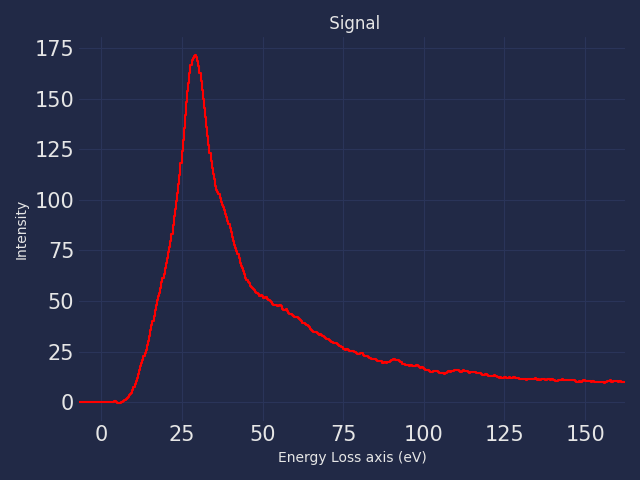

In [96]:
## Sapphire map and mean spectrum
MAP_sapphire.crop(axis=0,start=10.0, end=None,convert_units=True)
MAP_sapphire.plot()
Sapphire_mean = EELS_MAP_Modeled.nanmean()
Sapphire_mean.plot()

In [ ]:
## Sapphire map and mean spectrum
MAP_sapphire_InSe.crop(axis=0,start=10.0, end=None,convert_units=True)
MAP_sapphire_InSe.plot()
Sapphire_mean = EELS_MAP_Modeled.nanmean()
Sapphire_mean.plot()

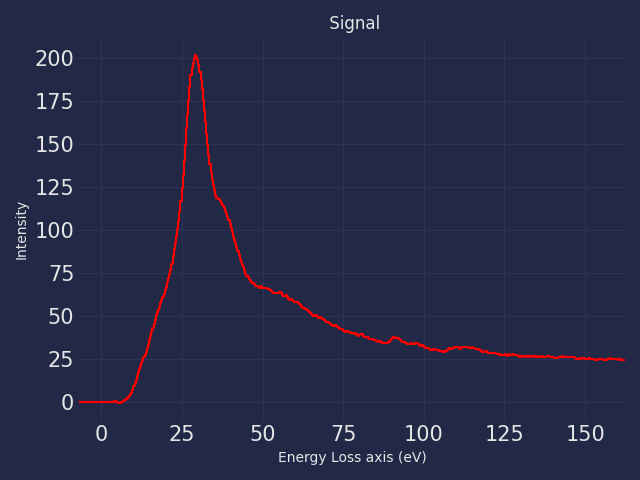

In [89]:
Sapphire_mean = EELS_MAP_Modeled.nanmean()
Sapphire_mean.plot()

In [70]:
## use the quick peak finder

##peak finder #position’, ‘height’, and ‘width
peaks = EELS_MAP_Modeled.find_peaks1D_ohaver(    
    xdim=None,
    slope_thresh=0.01,
    amp_thresh=0.1,
    subchannel=False, ## True makes wierd height and width values !!
    medfilt_radius=5,
    maxpeakn=4,
    peakgroup=10,
    num_workers=None,
)

# ## add peaks as point markers
# for eintrag in peaks[0]:
#     # print(eintrag[0:1])
#     offset = [eintrag[0],eintrag[1]]
#     Region1.add_marker(hs.plot.markers.Points(offset))

[########################################] | 100% Completed | 2.08 ss


In [74]:
peaks[1][1][:]

array([(29.89026373, 160.51966894, 0.), (72.89604408,  15.82283052, 0.),
       (79.83246026,   9.19569593, 0.), (80.87292269,  10.03520666, 0.)],
      dtype=[('position', '<f8'), ('height', '<f8'), ('width', '<f8')])

In [65]:
EELS_MAP_Modeled.

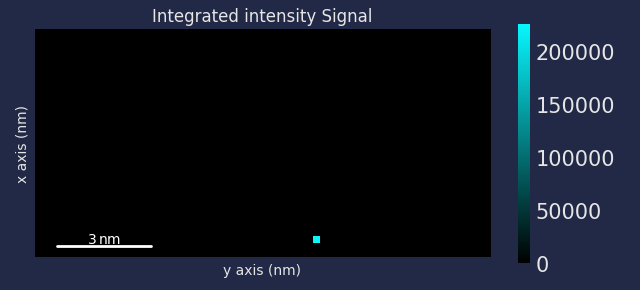

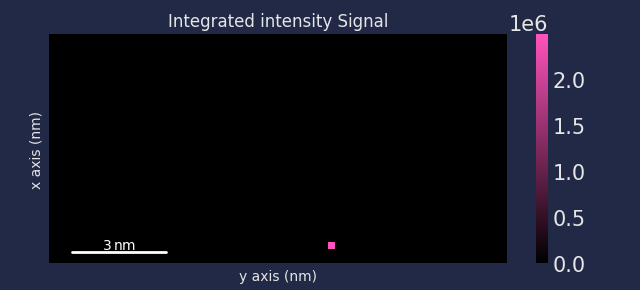

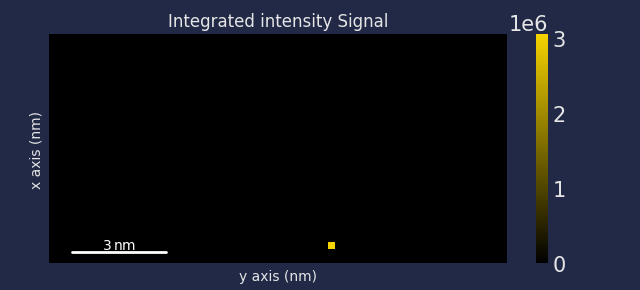

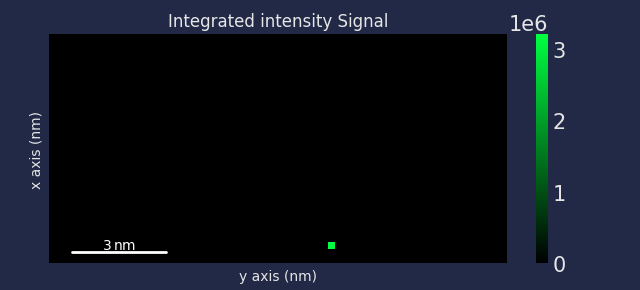

ValueError: not enough values to unpack (expected 4, got 2)

In [43]:
## extract maps from peaks
all_sum, rois, roi_signals, roi_sums = hs.plot.plot_roi_map(signal = EELS_MAP_background_corrected[0], rois = 4,single_figure=False,single_figure_kwargs={'vmin':10,'vmax':200})


In [116]:
test = EELS_MAP_mean_spekt.richardson_lucy_deconvolution(EELS_MAP_mean_spekt)

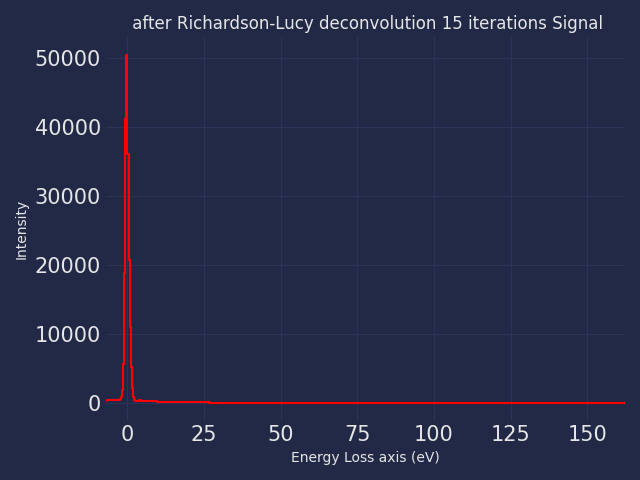

In [117]:
test.plot()

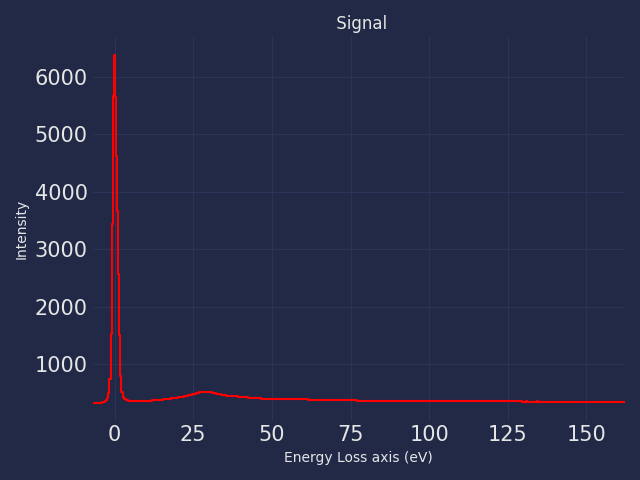

In [115]:
EELS_MAP_mean_spekt.plot()

<Axes: xlabel='Energy Loss (eV)', ylabel='Intensity'>

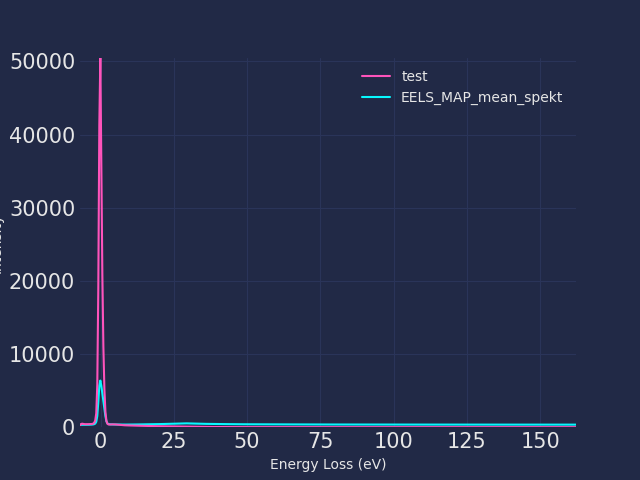

In [118]:
#plot multiple spectra in one figure
hs.plot.plot_spectra([EELS_MAP_mean_spekt,test],
    style='overlap',
    color=None,
    linestyle=None,
    drawstyle='default',
    padding=1.0,
    legend=['EELS_MAP_mean_spekt','test'],
    legend_picking=True,
    legend_loc='upper right',
    fig=None,
    ax=None,
    auto_update=None,
)

In [25]:
jupyter notebook --config-dir


SyntaxError: invalid syntax (885695878.py, line 1)

In [23]:
notebook --ServerApp.iopub_msg_rate_limit=1.0e10

UsageError: the following arguments are required: filename


In [ ]:
jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [101]:
EELS_MAP.plot()

In [95]:
signal_background_corrected.print_current_values()

Parameter Name,Free,Value,Std,Min,Max,Linear
A,True,1.46153e-05,48.8767,0,,True
left_cutoff,False,0,nan,,,False
origin,False,0,nan,,,False
r,True,0.181163,2.383e+06,1,5,False


{}

In [56]:
bkg= signal_background_corrected.as_dictionary()
bkg

{'components': [{'parameters': [{'_twins': [],
     '_id_name': 'A',
     'value': 1.4615334293921478e-05,
     'std': 48.8766786352941,
     'free': True,
     'units': '',
     'map': array([(1.46153343e-05, 48.87667864,  True)],
           dtype=[('values', '<f8'), ('std', '<f8'), ('is_set', '?')]),
     '_bounds': (0.0, None),
     'ext_bounded': False,
     'name': 'A',
     '_linear': True,
     'ext_force_positive': False,
     'twin_function_expr': '',
     'twin_inverse_function_expr': '',
     'self': 22671357639024,
     '_whitelist': {'_id_name': '',
      'value': '',
      'std': '',
      'free': '',
      'units': '',
      'map': '',
      '_bounds': '',
      'ext_bounded': '',
      'name': '',
      '_linear': '',
      'ext_force_positive': '',
      'twin_function_expr': '',
      'twin_inverse_function_expr': '',
      'self': 'id'}},
    {'_twins': [],
     '_id_name': 'left_cutoff',
     'value': 0.0,
     'std': nan,
     'free': False,
     'units': '',
     

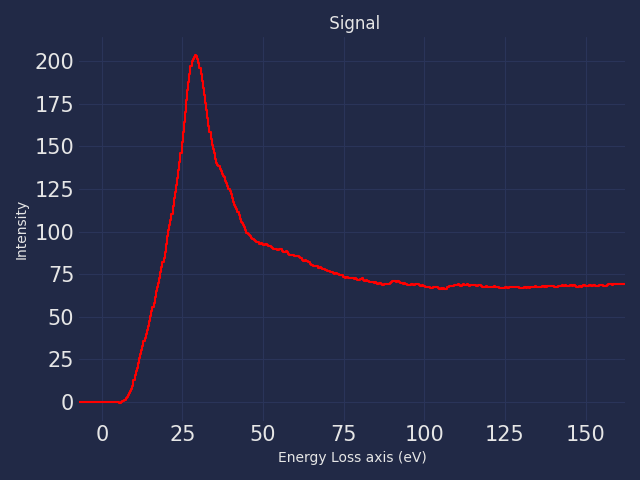

In [45]:
EELS_MAP_mean_spekt.plot()

In [123]:
## normalize MAP if needed
EELS_MAP = EELS_MAP/np.max(np.asarray(EELS_MAP))
EELS_MAP

In [58]:
## Shamail --> saving as rpl to use the Gatan Tools
EELS_MAP.save(filename=os.path.join(fp,'Test.rpl'))